In [1]:
from helper import *
import spacy

nlp = spacy.load("en_core_sci_md")

japflow_data = json.load(open("../data/japflow/all.json"))
risec_data = json.load(open("../data/risec/train.json"))

/usr0/home/rdutt/anaconda3/envs/amr/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
from helper import *
import stanza
import readability

stanza.download("en")
nlp = stanza.Pipeline("en")
datasets = ["risec", "japflow", "mscorpus", "chemu", "wsj"]

2022-04-20 22:52:08 INFO: Downloading default packages for language: en (English)...
2022-04-20 22:52:09 INFO: File exists: /usr0/home/rdutt/stanza_resources/en/default.zip.
2022-04-20 22:52:20 INFO: Finished downloading models and saved to /usr0/home/rdutt/stanza_resources.
2022-04-20 22:52:20 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2022-04-20 22:52:20 INFO: Use device: gpu
2022-04-20 22:52:20 INFO: Loading: tokenize
2022-04-20 22:52:20 INFO: Loading: pos
2022-04-20 22:52:21 INFO: Loading: lemma
2022-04-20 22:52:21 INFO: Loading: depparse
2022-04-20 22:52:21 INFO: Loading: sentiment
2022-04-20 22:52:22 INFO: Loading: constituency
2022-04-20 22:52:22 INFO: Loading: ner
2022-04-20 22:52:23 INFO: Done loading proces

## MDD and MHD calculation

In [18]:
import networkx as nx

depscores = ddict(lambda: ddict(list))

for dataset in datasets:
    all_data = json.load(open(f"../data/{dataset}/train.json"))
    bad_sents = 0
    cnt = 0
    for elem in tqdm(all_data):
        try:
            doc = nlp(elem["text"])
            for sent in doc.sentences:
                edges = [(word.head, word.id) for word in sent.words]
                mdd = np.mean([abs(edge[0] - edge[1]) for edge in edges])
                graph = nx.DiGraph(edges)
                mhd_dict = nx.single_source_shortest_path_length(graph, source=0)
                mhd = np.mean([mhd_dict[elem] for elem in mhd_dict])
                depscores[dataset]["mdd"].append(mdd)
                depscores[dataset]["mhd"].append(mhd)
        except Exception as e:
            bad_sents += 1
            continue

    print(bad_sents)

100%|██████████| 126/126 [00:43<00:00,  2.92it/s]


0


100%|██████████| 300/300 [01:44<00:00,  2.87it/s]


0


100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


0


100%|██████████| 720/720 [07:29<00:00,  1.60it/s]


39


100%|██████████| 1728/1728 [28:17<00:00,  1.02it/s]

1


In [25]:
for dataset in depscores:
    print(
        dataset + "\t",
        np.mean(depscores[dataset]["mdd"]),
        np.mean(depscores[dataset]["mhd"]),
        np.median(depscores[dataset]["mdd"]),
        np.median(depscores[dataset]["mhd"]),
    )

risec	 2.989321886824177 2.539308897150301 2.9375 2.5294117647058822
japflow	 3.0878412838985545 2.593930420600451 3.090909090909091 2.5833333333333335
mscorpus	 3.213898032983633 3.0123737801052966 3.2880184331797233 3.0
chemu	 3.407179450007151 3.373050557832743 3.361111111111111 3.28
wsj	 3.4529037041436648 3.2748757219622435 3.44 3.235294117647059


## READABILITY SCORES FOR DIFFERENT DATASETS

In [26]:
import pandas as pd

reading_scores = ddict(list)
all_metrics = ddict(lambda: ddict(int))

nlp = stanza.Pipeline(lang="en", processors="tokenize")
readability_scores = ddict(lambda: ddict(lambda: ddict(list)))
for dataset in datasets:
    all_data = json.load(open(f"../data/{dataset}/train.json"))
    for elem in tqdm(all_data):
        doc = nlp(elem["text"])
        text = "\n".join([sent.text for sent in doc.sentences])
        results = readability.getmeasures(text, lang="en")
        for metric in results:
            for submetric in results[metric]:
                readability_scores[metric][submetric][dataset].append(
                    results[metric][submetric]
                )

2022-04-20 23:38:20 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2022-04-20 23:38:20 INFO: Use device: gpu
2022-04-20 23:38:20 INFO: Loading: tokenize
2022-04-20 23:38:21 INFO: Done loading processors!
100%|██████████| 1728/1728 [04:15<00:00,  6.77it/s]


In [27]:
for metric in readability_scores:
    for submetric in readability_scores[metric]:
        for dataset in readability_scores[metric][submetric]:
            val = np.mean(readability_scores[metric][submetric][dataset])
            reading_scores[dataset].append(val)
        reading_scores["mean-metric"].append(submetric)

read_df = pd.DataFrame(reading_scores)
display(read_df)

,risec,japflow,mscorpus,chemu,wsj,mean-metric
0,3.312412,4.506464,8.721315,9.526143,9.957479,Kincaid
1,3.731710,5.156976,10.821319,12.549697,11.837323,ARI
2,5.891307,7.038908,10.728023,11.348932,11.091897,Coleman-Liau
3,91.194253,84.826005,67.293234,66.185771,61.173961,FleschReadingEase
4,7.796647,8.252785,15.306355,16.297810,14.169591,GunningFogIndex
5,27.714582,28.151091,47.001472,49.393523,48.538075,LIX
6,8.089760,8.237462,13.354064,13.885608,12.351991,SMOGIndex
7,1.834182,1.887067,5.319827,5.995492,5.792123,RIX
8,10.128375,8.582282,14.108348,15.760958,11.971627,DaleChallIndex
9,4.157306,4.329234,4.775770,4.864820,4.827970,characters_per_word


In [28]:
vocab_dict = ddict(list)

for dataset in datasets:
    all_data = json.load(open(f"../data/{dataset}/train.json"))
    for elem in tqdm(all_data):
        tokens = elem["text"].lower().split()
        vocab_dict[dataset].extend(tokens)

vocab_overlap = ddict(list)
for i, dataset1 in enumerate(datasets):
    vocab_overlap["dataset1"].append(dataset1)
    li = len(set(vocab_dict[dataset1]))
    for j, dataset2 in enumerate(datasets):
        lc = len(set(vocab_dict[dataset2]) & set(vocab_dict[dataset1]))
        vocab_overlap[dataset2].append(round(lc / li, 2))

vocab_overlap = pd.DataFrame(vocab_overlap)
display(vocab_overlap)

100%|██████████| 1728/1728 [00:00<00:00, 19076.71it/s]


,dataset1,risec,japflow,mscorpus,chemu,wsj
0,risec,1.00,0.66,0.23,0.19,0.56
1,japflow,0.38,1.00,0.19,0.14,0.53
2,mscorpus,0.07,0.09,1.00,0.21,0.32
3,chemu,0.04,0.05,0.15,1.00,0.16
4,wsj,0.02,0.03,0.03,0.02,1.00


### REPEAT THE ABOVE EXPERIMENTS WHEN THE ENTITIES ARE MASKED

In [1]:
from helper import *
import networkx as nx
import stanza

nlp = stanza.Pipeline(lang="en", processors="tokenize,pos,lemma,depparse")
depscores = ddict(list)
all_lbls = ddict(list)
rem_lbls = {}
train_texts = ddict(list)

for dataset in ["mscorpus", "risec", "chemu", "japflow"]:
    all_data = json.load(open(f"../data/{dataset}/train.json"))
    for elem in tqdm(all_data):
        text = elem["text"]
        anns = elem["anns"]
        all_lbls[dataset].extend([ann["label"] for ann in anns])

# for dataset in all_lbls:
#     print(dataset, Counter(all_lbls[dataset]))

/usr0/home/rdutt/anaconda3/envs/amr/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-04-28 13:38:47 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2022-04-28 13:39:51 INFO: Use device: gpu
2022-04-28 13:39:51 INFO: Loading: tokenize
2022-04-28 13:41:35 INFO: Loading: pos
2022-04-28 13:41:36 INFO: Loading: lemma
2022-04-28 13:41:36 INFO: Loading: depparse
2022-04-28 13:41:38 INFO: Done loading processors!
100%|██████████| 300/300 [00:00<00:00, 159438.82it/s]

mscorpus Counter({'Material': 3420, 'Number': 2951, 'Operation': 2593, 'Amount-Unit': 1153, 'Condition-Unit': 1112, 'Material-Descriptor': 1014, 'Property-Misc': 379, 'Condition-Misc': 376, 'Nonrecipe-Material': 341, 'Synthesis-Apparatus': 341, 'Brand': 226, 'Apparatus-Descriptor': 130, 'Property-Type': 125, 'Amount-Misc': 115, 'Meta': 99, 'Condition-Type': 99, 'Property-Unit': 97, 'Apparatus-Unit': 87, 'Reference': 86, 'Characterization-Apparatus': 84, 'Apparatus-Property-Type': 20})
risec Counter({'FOOD': 1561, 'AC': 1487, 'TOOL': 548, 'CONDITION_CLAUSE': 237, 'DUR': 208, 'TEMPERATURE': 195, 'OTHER': 132, 'PURPOSE_CLAUSE': 76})
chemu Counter({'OTHER_COMPOUND': 3702, 'REACTION_STEP': 3058, 'WORKUP': 2430, 'REACTION_PRODUCT': 1637, 'STARTING_MATERIAL': 1417, 'TEMPERATURE': 1203, 'REAGENT_CATALYST': 1018, 'SOLVENT': 915, 'YIELD_OTHER': 850, 'TIME': 848, 'YIELD_PERCENT': 764, 'EXAMPLE_LABEL': 714})
japflow Counter({'Ac': 4956, 'F': 4850, 'T': 1860, 'Sf': 1033, 'St': 868, 'D': 575, 'Q': 4

In [17]:
rem_lbls = {}
rem_lbls["mscorpus"] = {
    "Material": "material",
    "Nonrecipe-Material": "material",
    "Characterization-Apparatus": "equipment",
    "Synthesis-Apparatus": "equipment",
}
rem_lbls["chemu"] = {
    "OTHER_COMPOUND": "compound",
    "SOLVENT": "solvent",
    "STARTING_MATERIAL": "material",
    "REACTION_PRODUCT": "product",
    "REAGENT_CATALYST": "material",
}

train_texts = ddict(list)

for dataset in ["mscorpus", "chemu"]:
    all_data = json.load(open(f"../data/{dataset}/train.json"))
    for elem in tqdm(all_data):
        text, anns = elem["text"], elem["anns"]
        anns = sorted(
            [(ann["start"], ann["end"], ann["word"], ann["label"]) for ann in anns]
        )
        word_pos = 0
        for ann in anns:
            start, end, word, label = ann
            if label in rem_lbls[dataset]:
                text = (
                    text[: start + word_pos]
                    + rem_lbls[dataset][label]
                    + text[end + word_pos :]
                )
                word_pos += len(rem_lbls[dataset][label]) - (end - start)
                # word_pos            += len('it')-(end -start)

        train_texts[dataset].append(text)

100%|██████████| 720/720 [00:00<00:00, 26916.28it/s]


In [33]:
depscores = ddict(lambda: ddict(list))
nlp = stanza.Pipeline(lang="en", processors="tokenize,pos,lemma,depparse")
for dataset in ["mscorpus", "chemu"]:
    bad_sents = 0
    cnt = 0
    for text in tqdm(train_texts[dataset]):
        # print(text)
        doc = nlp(text)
        for sent in doc.sentences:
            try:
                # print(sent)
                edges = [(word.head, word.id) for word in sent.words]
                # print(edges)
                mdd = np.mean([abs(edge[0] - edge[1]) for edge in edges])
                graph = nx.DiGraph(edges)
                mhd_dict = nx.single_source_shortest_path_length(graph, source=0)
                mhd = np.mean([mhd_dict[elem] for elem in mhd_dict])
                depscores[dataset]["mdd"].append(mdd)
                depscores[dataset]["mhd"].append(mhd)

            except Exception as e:
                # break
                print(e)
                bad_sents += 1
    print(bad_sents)

2022-04-28 15:14:39 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2022-04-28 15:14:39 INFO: Use device: gpu
2022-04-28 15:14:39 INFO: Loading: tokenize
2022-04-28 15:14:40 INFO: Loading: pos
2022-04-28 15:14:40 INFO: Loading: lemma
2022-04-28 15:14:40 INFO: Loading: depparse
2022-04-28 15:14:41 INFO: Done loading processors!
100%|██████████| 150/150 [00:41<00:00,  3.63it/s]


0


100%|██████████| 720/720 [01:24<00:00,  8.53it/s]

0


In [35]:
for dataset in depscores:
    print(
        dataset + "\t",
        np.mean(depscores[dataset]["mdd"]),
        np.mean(depscores[dataset]["mhd"]),
        np.median(depscores[dataset]["mdd"]),
        np.median(depscores[dataset]["mhd"]),
    )

mscorpus	 3.1631677016744675 2.9538418695525555 3.25 2.9864864864864864
chemu	 3.233988871986604 3.202660384093901 3.2222222222222223 3.125


In [16]:
import readability

reading_scores = ddict(list)
nlp = stanza.Pipeline(lang="en", processors="tokenize")
mod_readability_scores = ddict(lambda: ddict(lambda: ddict(list)))
for dataset in ["mscorpus", "chemu"]:
    for text in tqdm(train_texts[dataset]):
        doc = nlp(text)
        text = "\n".join([sent.text for sent in doc.sentences])
        results = readability.getmeasures(text, lang="en")
        for metric in results:
            for submetric in results[metric]:
                mod_readability_scores[metric][submetric][dataset].append(
                    results[metric][submetric]
                )

for metric in mod_readability_scores:
    for submetric in mod_readability_scores[metric]:
        for dataset in mod_readability_scores[metric][submetric]:
            val = np.mean(mod_readability_scores[metric][submetric][dataset])
            reading_scores[dataset].append(val)
        reading_scores["mean-metric"].append(submetric)

read_df = pd.DataFrame(reading_scores)
display(read_df)

2022-04-28 14:45:59 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2022-04-28 14:45:59 INFO: Use device: gpu
2022-04-28 14:45:59 INFO: Loading: tokenize
2022-04-28 14:45:59 INFO: Done loading processors!
100%|██████████| 720/720 [00:20<00:00, 34.61it/s]


,mscorpus,chemu,mean-metric
0,7.479796,4.456937,Kincaid
1,8.099126,5.579919,ARI
2,7.703807,4.630015,Coleman-Liau
3,74.953534,96.104106,FleschReadingEase
4,13.768545,11.812992,GunningFogIndex
5,41.082362,37.528929,LIX
6,12.266808,10.604554,SMOGIndex
7,4.160008,3.466634,RIX
8,12.209286,13.264464,DaleChallIndex
9,4.271761,3.767997,characters_per_word


## Vocabulary Overlap Mismatch

In [2]:
risec_vocab, japflow_vocab, risec_ent_vocab, japflow_ent_vocab = (
    ddict(int),
    ddict(int),
    ddict(int),
    ddict(int),
)

for elem in japflow_data:
    words = [x.text.lower() for x in nlp(elem["text"])]
    for word in words:
        japflow_vocab[word] += 1

for elem in risec_data:
    words = [x.text.lower() for x in nlp(elem["text"])]
    for word in words:
        risec_vocab[word] += 1

for elem in japflow_data:
    anns = elem["anns"]
    for ann in anns:
        japflow_ent_vocab[ann["word"].lower()] += 1

for elem in risec_data:
    anns = elem["anns"]
    for ann in anns:
        risec_ent_vocab[ann["word"].lower()] += 1

risec_vocab_set = set(risec_vocab.keys())
japflow_vocab_set = set(japflow_vocab.keys())
risec_ent_set = set(risec_ent_vocab.keys())
japflow_ent_set = set(japflow_ent_vocab.keys())

oov_japflow = len(japflow_vocab_set - risec_vocab_set) / len(japflow_vocab_set)
oov_japflow_ent = len(japflow_ent_set - risec_ent_set) / len(japflow_ent_set)

print(oov_japflow, oov_japflow_ent)

0.5647977941176471 0.822380106571936


## Sentence Length Distribution

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.2)

risec_sent_dict, japflow_sent_dict = ddict(int), ddict(int)
tot_risec_sents, tot_japflow_sents = 0, 0
for elem in risec_data:
    sents = [x for x in nlp(elem["text"]).sents]
    for sent in sents:
        risec_sent_dict[min(len(sent), 40)] += 1
        tot_risec_sents += 1

for elem in japflow_data:
    sents = [x for x in nlp(elem["text"]).sents]
    for sent in sents:
        japflow_sent_dict[min(len(sent), 40)] += 1
        tot_japflow_sents += 1

sent_dict = ddict(list)
for elem in risec_sent_dict:
    sent_dict["length"].append(elem)
    sent_dict["prop"].append(risec_sent_dict[elem] / tot_risec_sents)
    sent_dict["data"].append("risec")

for elem in japflow_sent_dict:
    sent_dict["length"].append(elem)
    sent_dict["prop"].append(japflow_sent_dict[elem] / tot_japflow_sents)
    sent_dict["data"].append("japflow")

sent_df = pd.DataFrame(sent_dict)

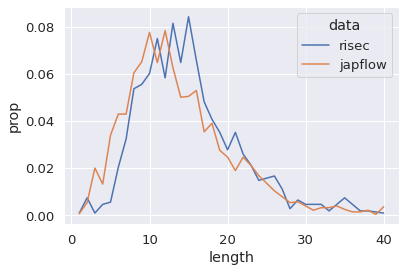

In [4]:
sns.lineplot(data=sent_df, x="length", y="prop", hue="data")
plt.show()

## Distribution of the dependency links between entities

In [24]:
risec_rels = load_dill(f"../data/risec/data.dill")["train"]["rels"]
japflow_rels = load_dill(f"../data/japflow/data.dill")["all"]["rels"]

In [13]:
import networkx as nx

risec_min_path_dict = ddict(int)

for rel in tqdm(risec_rels):
    org_toks, toks_range = rel["org_toks"], rel["tok_range"]
    sent = org_toks[0]
    for i in range(1, len(org_toks)):
        diff = toks_range[i][0] - toks_range[i - 1][1]
        for j in range(diff):
            sent += " "
        sent += org_toks[i]
    obj1_start, obj1_end, obj1_text = (
        rel["span_info"][0],
        rel["span_info"][1],
        rel["span_info"][2],
    )
    obj2_start, obj2_end, obj2_text = (
        rel["span_info"][4],
        rel["span_info"][5],
        rel["span_info"][6],
    )

    doc = nlp(sent)
    src_ents, tgt_ents, edges = [], [], []

    for token in doc:
        if token.pos_ in ["DET", "CONJ", "SYM"]:
            continue
        if token.text in obj1_text:
            src_ents.append(token.text)
        if token.text in obj2_text:
            tgt_ents.append(token.text)
        for child in token.children:
            edges.append(("{0}".format(token.text), "{0}".format(child.text)))

    graph = nx.Graph(edges)
    min_path = len(org_toks)

    for src in src_ents:
        for tgt in tgt_ents:
            try:
                min_path = min(
                    min_path, nx.shortest_path_length(graph, source=src, target=tgt)
                )
            except Exception as e:
                continue

    risec_min_path_dict[min_path] += 1

100%|██████████| 3689/3689 [00:35<00:00, 103.02it/s]


In [15]:
japflow_min_path_dict = ddict(int)

for rel in tqdm(japflow_rels):
    org_toks, toks_range = rel["org_toks"], rel["tok_range"]
    sent = org_toks[0]
    for i in range(1, len(org_toks)):
        diff = toks_range[i][0] - toks_range[i - 1][1]
        for j in range(diff):
            sent += " "
        sent += org_toks[i]
    obj1_start, obj1_end, obj1_text = (
        rel["span_info"][0],
        rel["span_info"][1],
        rel["span_info"][2],
    )
    obj2_start, obj2_end, obj2_text = (
        rel["span_info"][4],
        rel["span_info"][5],
        rel["span_info"][6],
    )

    doc = nlp(sent)
    src_ents, tgt_ents, edges = [], [], []

    for token in doc:
        if token.pos_ in ["DET", "CONJ", "SYM"]:
            continue
        if token.text in obj1_text:
            src_ents.append(token.text)
        if token.text in obj2_text:
            tgt_ents.append(token.text)
        for child in token.children:
            edges.append(("{0}".format(token.text), "{0}".format(child.text)))

    graph = nx.Graph(edges)

    min_path = len(org_toks)

    for src in src_ents:
        for tgt in tgt_ents:
            try:
                min_path = min(
                    min_path, nx.shortest_path_length(graph, source=src, target=tgt)
                )
            except Exception as e:
                continue
    japflow_min_path_dict[min_path] += 1

100%|██████████| 15861/15861 [02:51<00:00, 92.28it/s] 


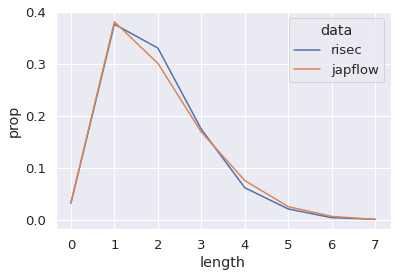

In [25]:
risec_deps = np.sum([risec_min_path_dict[elem] for elem in risec_min_path_dict])
japflow_deps = np.sum([japflow_min_path_dict[elem] for elem in japflow_min_path_dict])

dep_dict = ddict(list)

for path in risec_min_path_dict:
    dep_dict["length"].append(min(path, 7))
    dep_dict["prop"].append(risec_min_path_dict[path] / risec_deps)
    dep_dict["data"].append("risec")

for path in japflow_min_path_dict:
    dep_dict["length"].append(min(path, 7))
    dep_dict["prop"].append(japflow_min_path_dict[path] / japflow_deps)
    dep_dict["data"].append("japflow")

dep_df = pd.DataFrame(dep_dict)

sns.lineplot(data=dep_df, x="length", y="prop", hue="data")

plt.show()

In [29]:
for rel in tqdm(risec_rels):
    if rel["span_info"][-1] != "Arg_PAG":
        continue
    org_toks, toks_range = rel["org_toks"], rel["tok_range"]
    sent = org_toks[0]
    for i in range(1, len(org_toks)):
        diff = toks_range[i][0] - toks_range[i - 1][1]
        for j in range(diff):
            sent += " "
        sent += org_toks[i]
    obj1_start, obj1_end, obj1_text = (
        rel["span_info"][0],
        rel["span_info"][1],
        rel["span_info"][2],
    )
    obj2_start, obj2_end, obj2_text = (
        rel["span_info"][4],
        rel["span_info"][5],
        rel["span_info"][6],
    )
    print(sent, rel["span_info"])

print("\n\n****************************\n\n")
for rel in tqdm(japflow_rels):
    if rel["span_info"][-1] != "agent":
        continue
    org_toks, toks_range = rel["org_toks"], rel["tok_range"]
    sent = org_toks[0]
    for i in range(1, len(org_toks)):
        diff = toks_range[i][0] - toks_range[i - 1][1]
        for j in range(diff):
            sent += " "
        sent += org_toks[i]
    obj1_start, obj1_end, obj1_text = (
        rel["span_info"][0],
        rel["span_info"][1],
        rel["span_info"][2],
    )
    obj2_start, obj2_end, obj2_text = (
        rel["span_info"][4],
        rel["span_info"][5],
        rel["span_info"][6],
    )
    if sent.startswith("Let"):
        print(sent, rel["span_info"])

100%|██████████| 15861/15861 [00:00<00:00, 364785.08it/s]

12) When inserted it should come out clean. (589, 593, 'come', 'AC', 579, 581, 'it', 'TOOL', 'Arg_PAG')
4) Let them warm up for about 90 seconds. (183, 190, 'warm up', 'AC', 178, 182, 'them', 'FOOD', 'Arg_PAG')
8) Let them cool for 2 minutes before removing from cookie sheets to cool completely. (451, 455, 'cool', 'AC', 446, 450, 'them', 'FOOD', 'Arg_PAG')
9) Beat on low speed for 2 minutes. 10) Let stand for 2-3 minutes. (452, 457, 'stand', 'AC', 411, 415, 'Beat', 'AC', 'Arg_PAG')
3) Remove from the heat and let stand at room temperature until cold, several hours. (158, 163, 'stand', 'AC', 129, 135, 'Remove', 'AC', 'Arg_PAG')
7) Overbeaten egg whites lose volume and deflate when folded into other ingredients. (350, 354, 'lose', 'AC', 328, 349, 'Overbeaten egg whites', 'FOOD', 'Arg_PAG')
7) Overbeaten egg whites lose volume and deflate when folded into other ingredients. (366, 373, 'deflate', 'AC', 328, 349, 'Overbeaten egg whites', 'FOOD', 'Arg_PAG')
8) Be absolutely sure not a partic

In [ ]:
for rel in tqdm(risec_rels):
    if rel["span_info"][-1] != "Arg_":
        continue
    org_toks, toks_range = rel["org_toks"], rel["tok_range"]
    sent = org_toks[0]
    for i in range(1, len(org_toks)):
        diff = toks_range[i][0] - toks_range[i - 1][1]
        for j in range(diff):
            sent += " "
        sent += org_toks[i]
    obj1_start, obj1_end, obj1_text = (
        rel["span_info"][0],
        rel["span_info"][1],
        rel["span_info"][2],
    )
    obj2_start, obj2_end, obj2_text = (
        rel["span_info"][4],
        rel["span_info"][5],
        rel["span_info"][6],
    )
    print(sent, rel["span_info"])

print("\n\n****************************\n\n")
for rel in tqdm(japflow_rels):
    if rel["span_info"][-1] != "dest":
        continue
    org_toks, toks_range = rel["org_toks"], rel["tok_range"]
    sent = org_toks[0]
    for i in range(1, len(org_toks)):
        diff = toks_range[i][0] - toks_range[i - 1][1]
        for j in range(diff):
            sent += " "
        sent += org_toks[i]
    obj1_start, obj1_end, obj1_text = (
        rel["span_info"][0],
        rel["span_info"][1],
        rel["span_info"][2],
    )
    obj2_start, obj2_end, obj2_text = (
        rel["span_info"][4],
        rel["span_info"][5],
        rel["span_info"][6],
    )
    if sent.startswith("Let"):
        print(sent, rel["span_info"])

In [6]:
from transformer_srl import dataset_readers, models, predictors

predictor = predictors.SrlTransformersPredictor.from_path(
    "/projects/flow_graphs/models/srl_bert_base_conll2012.tar.gz", "transformer_srl"
)

In [19]:
sent = """
In a large saucepan, combine chocolate chips and 1 cup heavy cream.
20) Heat, stirring constantly, until chocolate is melted and smooth.
""".lower()
srls = predictor.predict(sentence=sent)
for frame in srls["verbs"]:
    print(frame)
    print()

{'verb': 'combine', 'description': '[ARGM-LOC: in a large saucepan] , [combine.01: combine] [ARG1: chocolate chips and 1 cup heavy cream . 20 ) heat] , [ARGM-PRD: stirring constantly , until chocolate is melted and smooth] .', 'tags': ['B-ARGM-LOC', 'I-ARGM-LOC', 'I-ARGM-LOC', 'I-ARGM-LOC', 'O', 'B-V', 'B-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'O', 'B-ARGM-PRD', 'I-ARGM-PRD', 'I-ARGM-PRD', 'I-ARGM-PRD', 'I-ARGM-PRD', 'I-ARGM-PRD', 'I-ARGM-PRD', 'I-ARGM-PRD', 'I-ARGM-PRD', 'O'], 'frame': 'combine.01', 'frame_score': 0.9999986886978149, 'lemma': 'combine'}
{'verb': 'stirring', 'description': 'in a large saucepan , combine chocolate chips and 1 cup heavy cream . 20 ) heat , [stir.01: stirring] [ARGM-TMP: constantly] , [ARGM-TMP: until chocolate is melted and smooth] .', 'tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-V', 'B-ARGM-TMP', 'O', 'B-ARGM-TMP', 'I-ARGM-TMP', '

In [5]:
from helper import *

srl_dict = load_pickle("../data/risec/srl_sents.pkl")

count = 0
for sent in srl_dict:
    count += 1
    if count == 10:
        break
    print(sent)
    print(srl_dict[sent])
    print()

In a large saucepan, combine chocolate chips and 1 cup heavy cream.
20) Heat, stirring constantly, until chocolate is melted and smooth.

{'nodes': {0: ['combine'], 1: ['In', 'a', 'large', 'saucepan'], 2: ['melted'], 3: ['chocolate'], 4: ['stirring'], 5: [], 6: ['is', 'melted'], 7: ['combine', 'chocolate', 'chips', 'and', '1', 'cup', 'heavy', 'cream', '.', '20', ')', 'Heat', ',', 'stirring', 'constantly', ',', 'until', 'chocolate', 'is']}, 'edge_index': [[0, 2, 4, 4, 4, 4, 7, 6, 6], [1, 3, 5, 5, 5, 6, 5, 5, 5]], 'edge_type': ['ARGM-LOC', 'ARG1', 'ARG1', 'ARGM-TMP', 'ARGM-TMP', 'ARGM-TMP', 'ARG1', 'ARG1', 'ARG2']}

1) Cream together butter, peanut butter and sugars.
2) Beat in eggs.

{'nodes': {0: ['Beat'], 1: ['eggs']}, 'edge_index': [[0], [1]], 'edge_type': ['ARG1']}

8) Bake in a preheated oven for 8 to 10 minutes or until golden brown.

{'nodes': {}, 'edge_index': [[], []], 'edge_type': []}

4) Measure 1/2 cup of the mixture into re-sealable bags or containers for storage.
5) Label 

# Performance for AMRLIB

In [5]:
import amrlib, spacy
from helper import load_pickle
from amrlib.graph_processing.annotator import add_lemmas
import re
from amrlib.alignments.rbw_aligner import RBWAligner
import json
from helper import *
from intervals import *

bad_sents = []
graph_len = []
amr_sents = []
data_dir = "../data/risec"
split = "train"
docs = json.load(open(f"{data_dir}/{split}.json"))
nlp = spacy.load("en_core_sci_md")

for count, doc in enumerate(docs):
    print(f"Done for {count}/{len(docs)}", end="\r")
    rel_map = {}
    lbl_cnt = ddict(int)
    interdict = ddict(list)
    parses_arr = []

    sents = [x for x in nlp(doc["text"]).sents]

    for rel in doc["rels"]:
        start_span = min(rel["arg1_start"], rel["arg2_start"])
        end_span = max(rel["arg1_end"], rel["arg2_end"])
        rel_map[(start_span, end_span)] = (
            rel["arg1_start"],
            rel["arg1_end"],
            rel["arg1_word"],
            rel["arg1_label"],
            rel["arg2_start"],
            rel["arg2_end"],
            rel["arg2_word"],
            rel["arg2_label"],
            rel["arg_label"],
        )

    # sent_idxs = [0]+[max([tok.idx for tok in sent])+1 for sent in sents]
    sent_idxs = [0] + [sent.end_char for sent in sents]
    sent_ints = [(sent_idxs[i], sent_idxs[i + 1]) for i in range(0, len(sent_idxs) - 1)]
    rel_ints = sorted(rel_map)

    for rel_start, rel_end in rel_ints:
        for sent_cnt, sent in enumerate(sent_ints):
            sent_start, sent_end = sent_ints[sent_cnt]
            if rel_start > sent_end:
                continue
            if rel_end < sent_start:
                break
            interdict[(rel_start, rel_end)].append(
                (sents[sent_cnt], sent_ints[sent_cnt][0])
            )

    for rel_int in interdict:
        (
            arg1_start,
            arg1_end,
            arg1_word,
            arg1_label,
            arg2_start,
            arg2_end,
            arg2_word,
            arg2_label,
            arg_lbl,
        ) = rel_map[rel_int]
        arg1_ann_map, arg2_ann_map, bw_arg_ann_map = (
            IntervalMapping(),
            IntervalMapping(),
            IntervalMapping(),
        )

        arg1_ann_map[arg1_start:arg1_end] = (arg1_start, arg1_end, arg1_label)
        arg2_ann_map[arg2_start:arg2_end] = (arg2_start, arg2_end, arg2_label)
        bw_arg_ann_map[min(arg1_start, arg2_start) : max(arg2_end, arg1_end)]

        sent_str, sent_start = "", None

        for elem in interdict[rel_int]:
            sent, sent_start_pos = elem
            if sent_start is None:
                sent_start = sent_start_pos
            # sent_str 						+=str(sent.strip())
            sent_str += str(sent)
            sent_toks = sent

        amr_sents.append(sent_str)

print(f"Total number of sentences = {len(amr_sents)}")

Total number of sentences = 3689


In [45]:
import numpy as np
from transformers import AutoTokenizer, AutoModel

bert_model = "bert-base-uncased"
nlp = spacy.load("en_core_sci_md")

amrlib.setup_spacy_extension()
tokenizer = AutoTokenizer.from_pretrained(bert_model)
model = AutoModel.from_pretrained(bert_model)
amr_dict = ddict(dict)

for sent in tqdm(list(amr_sents[:10])):
    sent = sent.replace("\n", "\u00A0")
    doc = nlp(sent)

    node_dict = {}
    edges_arr = []
    node2str = {}
    node2embs = {}

    for count, span in enumerate(doc.sents):
        start_tok_idx, end_tok_idx = 1, 1
        tok_pos = []
        bert_toks = tokenizer(span.text, return_tensors="pt")
        bert_embs = model(**bert_toks)["last_hidden_state"][0]
        input_ids = list(np.array(bert_toks["input_ids"].squeeze(dim=0).cpu()))

        graph_string = span._.to_amr()
        penman_graph = add_lemmas(graph_string[0], snt_key="snt")
        aligner = RBWAligner.from_penman_w_json(
            penman_graph
        )  # use this with an annotated penman graph object
        aligned_string = aligner.get_graph_string()
        alignments = (
            aligned_string.split("::")[4]
            .split("\n")[0]
            .replace("alignments", "")
            .strip()
            .split()
        )
        tokens = ast.literal_eval(
            aligned_string.split("::")[2].split("\n")[0][len("tokens") + 1 :]
        )

        for tok_idx, tok_str in enumerate(tokens):
            curr_bert_toks = tokenizer.encode(tok_str, add_special_tokens=False)
            end_tok_idx = start_tok_idx + len(curr_bert_toks)
            tok_pos.append((tok_str, tok_idx, start_tok_idx, end_tok_idx))
            start_tok_idx = end_tok_idx

        triples = penman_graph.triples
        edges = penman_graph.edges()

        for n1, rel, n2 in edges:
            n1 = f"{count}-{n1}"
            n2 = f"{count}-{n2}"
            if n1 not in node_dict:
                node_dict[n1] = len(node_dict)
            if n2 not in node_dict:
                node_dict[n2] = len(node_dict)

        for edge in edges:
            src, rel, tgt = edge.source, edge.role, edge.target
            edges_arr.append((f"{count}-{src}", rel, f"{count}-{tgt}"))

        last_aligned_str = aligned_string.split("::")[4]
        aligned_idx = last_aligned_str.index("\n") + 1
        aligned_graph_strs = last_aligned_str[aligned_idx:].strip().split("\n")

        last_node = None
        for aligned_node in aligned_graph_strs:
            e_match = re.search(r"~e\.\d+", aligned_node)
            z_match = re.search(r"\(z\d+ \/", aligned_node)
            if e_match is not None and z_match is not None:
                e_tok = int(e_match[0].split(".")[1])
                z_node = z_match[0][1:].split("/")[0]
                node2str[f"{count}-{z_node}"] = tok_pos[e_tok]
                last_node = z_node
            elif z_match is not None:
                z_node = z_match[0][1:].split("/")[0]
                last_node = z_node
            elif e_match is not None:
                e_tok = int(e_match[0].split(".")[1])
                node2str[f"{count}-{last_node}"] = tok_pos[e_tok]

        for node in node2str:
            if not node.startswith(f"{count}-"):
                continue
            try:
                start_idx, end_idx = node2str[node][2], node2str[node][3]
                node2embs[node] = torch.max(bert_embs[start_idx:end_idx], dim=0)[0]
            except:
                node2embs[node] = torch.max(bert_embs[start_idx], dim=0)[0]

    amr_dict[sent]["node2str"] = node2str
    amr_dict[sent]["node2embs"] = node2embs
    amr_dict[sent]["edges_arr"] = edges_arr
    amr_dict[sent]["node_dict"] = node_dict
    amr_dict[sent]["triples"] = penman_graph.triples
    amr_dict[sent]["tok_pos"] = tok_pos
    amr_dict[sent]["aligned_graph"] = aligned_graph_strs
    amr_dict[sent]["graph_str"] = graph_string[0]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


In [46]:
print(sent)
pprint(aligned_string)

 2) Whisk in egg yolks and cook until light custard forms; do not boil. 3) Remove from heat and cool, then place in refrigerator and chill overnight.
('# ::snt 3) Remove from heat and cool, then place in refrigerator and chill '
 'overnight.\n'
 '# ::tokens ["3", ")", "Remove", "from", "heat", "and", "cool", ",", "then", '
 '"place", "in", "refrigerator", "and", "chill", "overnight", "."]\n'
 '# ::lemmas ["3", ")", "remove", "from", "heat", "and", "cool", ",", "then", '
 '"place", "in", "refrigerator", "and", "chill", "overnight", "."]\n'
 '# ::alignments 0-1.1 2-1.2 4-1.2.2.1 5-1 6-1.2.2.2 8-1.3.3 9-1.3.1 '
 '11-1.3.1.2 12-1.2.2 13-1.3.2 14-1.3.4\n'
 '(z1 / and~e.5\n'
 '      :li 3~e.0\n'
 '      :op1 (z2 / remove-01~e.2\n'
 '            :ARG1 (z3 / you)\n'
 '            :ARG2 (z4 / and~e.12\n'
 '                  :op1 (z5 / heat~e.4)\n'
 '                  :op2 (z6 / cool~e.6)))\n'
 '      :op2 (z7 / and\n'
 '            :op1 (z8 / place-01~e.9\n'
 '                  :ARG1 z3\n'
 '  

In [47]:
pprint(amr_dict[sent]["node2str"])

{'0-z1 ': ('2', 0, 1, 2),
 '0-z10 ': ('light', 9, 14, 15),
 '0-z11 ': ('not', 14, 21, 22),
 '0-z2 ': ('Whisk', 2, 3, 6),
 '0-z4 ': ('yolks', 5, 8, 11),
 '0-z5 ': ('egg', 4, 7, 8),
 '0-z6 ': ('cook', 7, 12, 13),
 '0-z7 ': ('until', 8, 13, 14),
 '0-z8 ': ('forms', 11, 18, 19),
 '0-z9 ': ('custard', 10, 15, 18),
 '1-z1 ': ('3', 0, 1, 2),
 '1-z10 ': ('chill', 13, 14, 15),
 '1-z11 ': ('then', 8, 9, 10),
 '1-z12 ': ('overnight', 14, 15, 16),
 '1-z2 ': ('Remove', 2, 3, 4),
 '1-z4 ': ('and', 12, 13, 14),
 '1-z5 ': ('heat', 4, 5, 6),
 '1-z6 ': ('cool', 6, 7, 8),
 '1-z8 ': ('place', 9, 10, 11),
 '1-z9 ': ('refrigerator', 11, 12, 13)}


In [5]:
from helper import *
from intervals import *


def dump_amrs(data_dir, splits, bert_model, text_tokenizer="scispacy"):

    from transformers import AutoTokenizer, AutoModel

    bad_counts = 0
    import amrlib, spacy
    from amrlib.graph_processing.annotator import add_lemmas
    from amrlib.alignments.rbw_aligner import RBWAligner

    tokenizer = AutoTokenizer.from_pretrained(bert_model)
    model = AutoModel.from_pretrained(bert_model)

    amrlib.setup_spacy_extension()

    if text_tokenizer == "scispacy":
        nlp = spacy.load("en_core_sci_md")
    elif text_tokenizer == "spacy":
        nlp = spacy.load("en_core_web_sm")

    bad_amr_sents = open(f"{data_dir}/bad_amr_sents.log", "w")
    sent_amr_dict = {}
    amr_sents = set()
    for split in splits:
        docs = json.load(open(f"{data_dir}/{split}.json"))
        for count, doc in enumerate(docs):
            print(f"Done for {count}/{len(docs)}", end="\r")
            rel_map = {}
            lbl_cnt = ddict(int)
            interdict = ddict(list)
            parses_arr = []

            sents = [x for x in nlp(doc["text"]).sents]

            for rel in doc["rels"]:
                start_span = min(rel["arg1_start"], rel["arg2_start"])
                end_span = max(rel["arg1_end"], rel["arg2_end"])
                rel_map[(start_span, end_span)] = (
                    rel["arg1_start"],
                    rel["arg1_end"],
                    rel["arg1_word"],
                    rel["arg1_label"],
                    rel["arg2_start"],
                    rel["arg2_end"],
                    rel["arg2_word"],
                    rel["arg2_label"],
                    rel["arg_label"],
                )

            # sent_idxs = [0]+[max([tok.idx for tok in sent])+1 for sent in sents]
            sent_idxs = [0] + [sent.end_char for sent in sents]
            sent_ints = [
                (sent_idxs[i], sent_idxs[i + 1]) for i in range(0, len(sent_idxs) - 1)
            ]
            rel_ints = sorted(rel_map)

            for rel_start, rel_end in rel_ints:
                for sent_cnt, sent in enumerate(sent_ints):
                    sent_start, sent_end = sent_ints[sent_cnt]
                    if rel_start > sent_end:
                        continue
                    if rel_end < sent_start:
                        break
                    interdict[(rel_start, rel_end)].append(
                        (sents[sent_cnt], sent_ints[sent_cnt][0])
                    )

            for rel_int in interdict:
                (
                    arg1_start,
                    arg1_end,
                    arg1_word,
                    arg1_label,
                    arg2_start,
                    arg2_end,
                    arg2_word,
                    arg2_label,
                    arg_lbl,
                ) = rel_map[rel_int]
                arg1_ann_map, arg2_ann_map, bw_arg_ann_map = (
                    IntervalMapping(),
                    IntervalMapping(),
                    IntervalMapping(),
                )

                arg1_ann_map[arg1_start:arg1_end] = (arg1_start, arg1_end, arg1_label)
                arg2_ann_map[arg2_start:arg2_end] = (arg2_start, arg2_end, arg2_label)
                bw_arg_ann_map[min(arg1_start, arg2_start) : max(arg2_end, arg1_end)]

                sent_str, sent_start = "", None

                for elem in interdict[rel_int]:
                    sent, sent_start_pos = elem
                    if sent_start is None:
                        sent_start = sent_start_pos
                    sent_str += str(sent)
                    sent_toks = sent
                    amr_sents.add(sent_str)

    print(f"Total number of sentences = {len(amr_sents)}")
    return amr_sents

In [6]:
scispacy_sents = dump_amrs(
    "../data/risec/",
    ["train", "dev", "test"],
    bert_model="bert-base-uncased",
    text_tokenizer="scispacy",
)
spacy_sents = dump_amrs(
    "../data/risec/",
    ["train", "dev", "test"],
    bert_model="bert-base-uncased",
    text_tokenizer="spacy",
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total number of sentences = 2544


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total number of sentences = 3293


In [6]:
# common_sents = scispacy_sents & spacy_sents
import amrlib, spacy
from amrlib.graph_processing.annotator import add_lemmas
from amrlib.alignments.rbw_aligner import RBWAligner

amrlib.setup_spacy_extension()
nlp_med = spacy.load("en_core_sci_md")
nlp_web = spacy.load("en_core_web_sm")
good_spans = []

In [7]:
sent_str = "1) Preheat oven to 350 degrees F (175 degrees C)."
doc = nlp_med(sent_str)

for span in doc.sents:
    graph_string = span._.to_amr()
    penman_graph = add_lemmas(graph_string[0], snt_key="snt")
    aligner = RBWAligner.from_penman_w_json(
        penman_graph
    )  # use this with an annotated penman graph object
    aligned_string = aligner.get_graph_string()

    print(aligned_string)

# ::snt 1) Preheat oven to 350 degrees F (175 degrees C).
# ::tokens ["1", ")", "Preheat", "oven", "to", "350", "degrees", "F", "(", "175", "degrees", "C", ")", "."]
# ::lemmas ["1", ")", "preheat", "oven", "to", "350", "degrees", "F", "(", "175", "degrees", "C", ")", "."]
# ::alignments 0-1.1 2-1 3-1.2 5-1.3.1
(z1 / preheat-00~e.2
      :li 1~e.0
      :ARG1 (z2 / oven~e.3)
      :ARG2 (z3 / temperature-quantity
            :quant 350~e.5
            :scale (z4 / fahrenheit)))


In [9]:
penman_graph.triples

[('z1', ':instance', 'preheat-00'),
 ('z1', ':li', '1'),
 ('z1', ':ARG1', 'z2'),
 ('z2', ':instance', 'oven'),
 ('z1', ':ARG2', 'z3'),
 ('z3', ':instance', 'temperature-quantity'),
 ('z3', ':quant', '350'),
 ('z3', ':scale', 'z4'),
 ('z4', ':instance', 'fahrenheit')]

In [50]:
for sent in tqdm(list(common_sents)):
    # sent           = sent.replace(')','ʅ').replace('(','ʃ')
    sent = sent.replace("\n", " ")
    doc = nlp_med(sent)
    for count, span in enumerate(doc.sents):
        graph_string = span._.to_amr()
        penman_graph = add_lemmas(graph_string[0], snt_key="snt")
        aligner = RBWAligner.from_penman_w_json(
            penman_graph
        )  # use this with an annotated penman graph object
        aligned_string = aligner.get_graph_string()
        alignments = (
            aligned_string.split("::")[4]
            .split("\n")[0]
            .replace("alignments", "")
            .strip()
            .split()
        )
        tokens = ast.literal_eval(
            aligned_string.split("::")[2].split("\n")[0][len("tokens") + 1 :]
        )

# print(len(bad_spans))
# print(len(common_sents))
# print(len(good_spans))

 41%|████      | 563/1390 [09:29<13:56,  1.01s/it]


KeyboardInterrupt: 

In [ ]:
CUDA_VISIBLE_DEVICES=3 python3 rel_classification_info.py --mode train --src_dataset chemu --tgt_dataset chemu --node_vec 768 --alpha 1 --gpu 3 --dep 1 --batch_size 10 --node_vec 768 &

CUDA_VISIBLE_DEVICES=2 python3 rel_classification_info.py --mode train --src_dataset chemu --tgt_dataset chemu --node_vec 768 --alpha 1 --gpu 3 --dep 0 --batch_size 10 --node_vec 768 &

CUDA_VISIBLE_DEVICES=0 python3 rel_classification_info.py --mode train --src_dataset mscorpus --tgt_dataset mscorpus --node_vec 768 --alpha 1 --gpu 3 --dep 1 --batch_size 10 --node_vec 768 &

CUDA_VISIBLE_DEVICES=1 python3 rel_classification_info.py --mode train --src_dataset mscorpus --tgt_dataset mscorpus --node_vec 768 --alpha 1 --gpu 3 --dep 0 --batch_size 10 --node_vec 768 &

CUDA_VISIBLE_DEVICES=4 python3 rel_classification_info.py --mode eval --src_dataset risec --tgt_dataset risec --node_vec 768 --alpha 1 --gpu 3 --dep 1 --batch_size 10 --node_vec 768 &

CUDA_VISIBLE_DEVICES=5 python3 rel_classification_info.py --mode eval --src_dataset risec --tgt_dataset risec --node_vec 768 --alpha 1 --gpu 3 --dep 0 --batch_size 10 --node_vec 768 &


In [1]:
! pip install python-igraph

  Using cached python_igraph-0.9.10-py3-none-any.whl (9.1 kB)
     |████████████████████████████████| 3.1 MB 5.8 MB/s eta 0:00:01
  Using cached texttable-1.6.4-py2.py3-none-any.whl (10 kB)


In [5]:
from helper import *
from igraph import *

data_dir = "../data/"
lex_lang = ddict(list)
dep_lang = ddict(list)
sent_lang = ddict(list)


def get_dep(dep_data):
    edges = dep_data.edge_index.cpu().detach().numpy()
    n1_mask, n2_mask = (
        dep_data.n1_mask.cpu().detach().numpy(),
        dep_data.n2_mask.cpu().detach().numpy(),
    )
    src_nodes = np.where(n1_mask == 1)[0]
    tgt_nodes = np.where(n2_mask == 1)[0]
    graph = Graph(directed=False)
    graph.add_vertices(list(range(len(n1_mask))))
    graph.add_edges([(n1, n2) for n1, n2 in zip(edges[0], edges[1])])
    try:
        sp = min(
            [min(path_len) for path_len in graph.shortest_paths(src_nodes, tgt_nodes)]
        )
    except Exception as e:
        if len(src_nodes) > 0 and len(tgt_nodes) > 0:
            sp = 0
        else:
            raise AssertionError

    return sp


for dataset in ["risec", "chemu", "mscorpus"]:
    src_file = f"{data_dir}/{dataset}/data.dill"
    src_dataset = load_dill(src_file)

    for split in ["train", "test", "dev"]:
        data = src_dataset[split]["rels"]
        for idx in tqdm(range(0, len(data))):
            arg1_start, arg2_start = data[idx]["arg1_ids"].index(1), data[idx][
                "arg2_ids"
            ].index(1)
            arg1_end, arg2_end = (
                arg1_start + np.sum(data[idx]["arg1_ids"]) - 1,
                arg2_start + np.sum(data[idx]["arg2_ids"]) - 1,
            )
            lex_dist = max(arg1_start, arg2_start) - min(arg1_end, arg2_end)
            lex_lang[dataset].append(lex_dist)
            sp = get_dep(data[idx]["dep_data"])
            dep_lang[dataset].append(sp)
            sent_lang[dataset].append(len(data[idx]["tokens"]))

100%|██████████| 2287/2287 [00:00<00:00, 5536.74it/s]


In [7]:
print("Sent tokens")
for lang in sent_lang:
    print(
        lang,
        np.mean(sent_lang[lang]),
        np.median(sent_lang[lang]),
        np.std(sent_lang[lang]),
    )

print("Lexical distance")

for lang in lex_lang:
    print(
        lang, np.mean(lex_lang[lang]), np.median(lex_lang[lang]), np.std(lex_lang[lang])
    )

print("Dependency distance")
for lang in dep_lang:
    print(
        lang, np.mean(dep_lang[lang]), np.median(dep_lang[lang]), np.std(dep_lang[lang])
    )

Sent tokens
risec 32.70939270188381 28.0 17.638530566502116
chemu 95.01055139550715 67.0 76.74612624826047
mscorpus 72.25805750312517 61.0 44.951131283328365
Lexical distance
risec 5.71136872612304 4.0 5.449745363434207
chemu 13.630530973451327 6.0 20.11730214797887
mscorpus 7.6212294146421 3.0 12.20073992286967
Dependency distance
risec 1.7432485838492953 1.0 1.2074174376122024
chemu 2.0372135239391875 2.0 1.3776306997605046
mscorpus 1.8618403174085547 1.0 1.5268098532557821
